# **発電量のデータを分析する**

### **必要な関数・モジュール**

In [1]:
# データ加工・処理・分析モジュール
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import random

%matplotlib inline

import time

In [2]:
def set_time(dataframe, col_name):
    '''
    to_datetimeを使うための前処理
    '''
    dataframe[col_name] = dataframe[col_name].map(lambda x : transform_time(x))
    return dataframe

In [3]:
def transform_time(x):
    '''
    set_time内で使う関数
    to_datetimeで24時をサポートしないので00に変更する処理
    '''
    str_x = str(x)
    res = ''
    if str(x)[8:10] == '24':
        res = str_x[0:4] + '-' + str_x[4:6] + '-' + str_x[6:8] + ' 00:'+str_x[10:12] 
    else:
        res = str_x[0:4] + '-' + str_x[4:6] + '-' + str_x[6:8] + ' '+ str_x[8:10] +':'+str_x[10:12]
    return res

In [4]:
def get_hours(x):
    '''
    時間帯毎に分類するための関数
    '''
    num = 0
    num += int(x.hour) * 2
    if int(x.minute) == 30:
        num += 1
    return num

In [5]:
def denormalize_array(normalized_x, x_min, x_max):
    '''
    正規化前のmin, maxを用いて元のスケールに戻す
    '''
    normalized_x = np.array(normalized_x)
    denormalize_array = (normalized_x) * (x_max - x_min) + x_min
    return denormalize_array

In [6]:
def get_input_data(X):
    '''
    全時系列データから00:00 ~ 20:00までのデータごとに分割する
    '''
    input_list = []
    # 一日は48個の時間帯に分けられる
    total_size = len(X) // 48
    reshaped_size = X[0:41].shape[0] * X[0:41].shape[1]
    for i in range(total_size+1):
        each_data = X[(i*48):(i*48+41)]
        reshaped = each_data.reshape(reshaped_size)
        input_list.append(list(reshaped))
    input_list = np.array(input_list)
    return input_list

In [7]:
def get_output_data(Y):
    '''
    全時系列データから00:00 ~ 23:30までのデータごとに分割する
    '''
    output_list = []
    # 一日は48個の時間帯に分けられる
    total_size = len(Y) // 48
    for i in range(total_size):
        each_data = Y[(i*48):(i*48+48)]
        reshaped = each_data.reshape(48)
        output_list.append(list(reshaped))
    output_list = np.array(output_list)
    return output_list

In [8]:
def drop_nan(X, Y):
    '''
    Yにnanが含まれるペアを削除(他のとこにあるdrop_nanとは別物なので注意)
    '''
    mask = []
    for i in range(len(Y)):
        if np.isnan(Y[i]).sum() == 0:
            mask.append(True)
        else:
            mask.append(False)
    X = X[mask]
    Y = Y[mask]
    return X, Y

In [9]:
def calc_mae(X, Y):
    '''
    X, Yがメモリを食いすぎるのでfor文で計算
    '''
    mse = 0
    for i in range(len(X)):
        mse += np.abs(X[i]- Y[i])
    return mse/len(X)

### **データを読み込む**

In [16]:
# 発電量データ
output_30 = pd.read_csv('data/processed_data/out_put.tsv', delimiter = '\t')
# output_data = set_time(output_data, 'datetime')
output_30['datetime'] = output_30['datetime'].map(lambda x : pd.to_datetime(x))

### **とりあえず浮島から** 

In [7]:
output_30_1 = output_30[['datetime', 'SOLA01']]
output_30_2 = output_30[['datetime', 'SOLA02']]
output_30_3 = output_30[['datetime', 'SOLA03']]

In [66]:
output_30_1['hours'] = output_30_1['datetime'].map(lambda x: get_hours(x))
output_30_1['month'] = output_30_1['datetime'].map(lambda x: x.month)
output_30_1['year'] = output_30_1['datetime'].map(lambda x: x.year)

In [41]:
groupby_hours_1 = output_30_1.groupby(['hours'], as_index=False).mean()

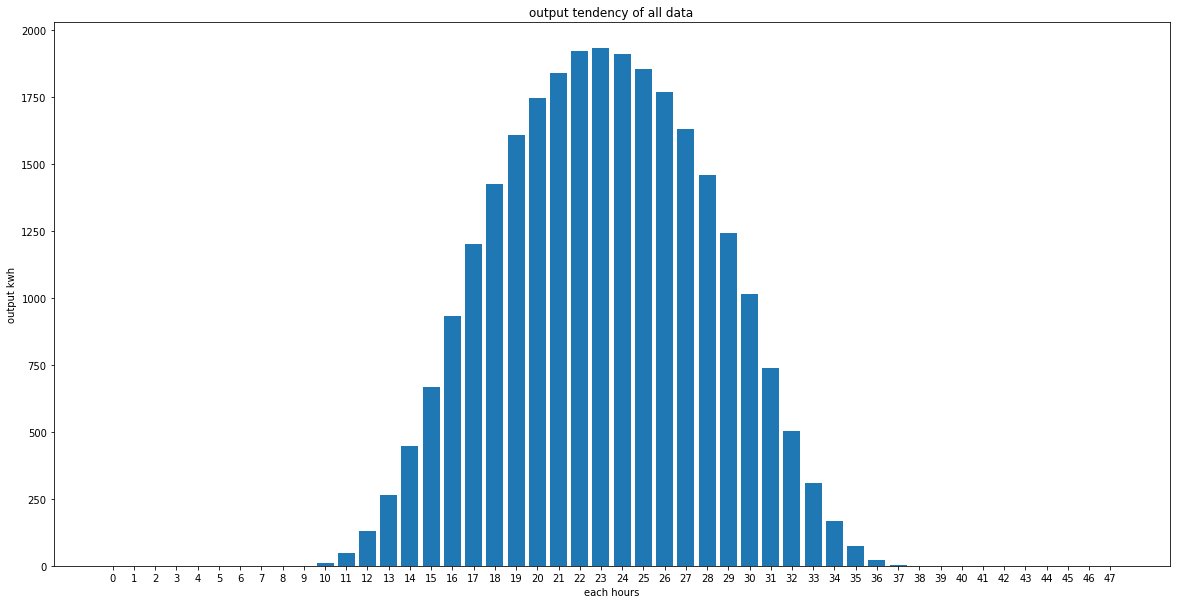

In [61]:
left = np.array(groupby_hours_1['hours'])
height = np.array(groupby_hours_1['SOLA01'])
plt.figure(figsize=(20, 10))
plt.bar(left, height, tick_label = np.arange(48), width=0.8)
plt.title("output tendency of all data")
plt.xlabel("each hours")
plt.ylabel("output kwh")
# plt.grid(True)

** 0:00 ~ 4:00, 19:00 ~ 23:30の間は4年間一度も発電してない(当たり前) ** 

** この時間帯は予測の対象から外してもいいかも?(スコアは数ポイントしか改善しなさそう)**

### **より詳細な分析**

In [70]:
groupby_detail_1 = output_30_1.groupby(['year', 'month', 'hours'], as_index=False).mean()

In [78]:
# 年毎のデータに分ける
yearly = []
for i in [2012, 2013, 2014, 2015]:
    yearly.append(groupby_detail_1[groupby_detail_1['year'] == i])

In [79]:
# 月ごとのデータに分ける
monthly = []
for i in range(12):
    monthly.append(groupby_detail_1[groupby_detail_1['month'] == (i+1)])

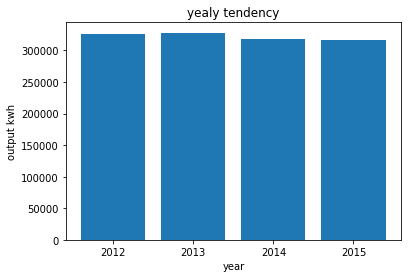

In [86]:
tmp = groupby_detail_1.groupby(['year'], as_index = False).sum()
left = np.array(tmp['year'])
height = np.array(tmp['SOLA01'])
# plt.figure(figsize=(20, 10))
plt.bar(left, height, tick_label = [2012, 2013, 2014, 2015], width=0.8)
plt.title("yealy tendency")
plt.xlabel("year")
plt.ylabel("output kwh")

In [63]:
monthly_output = output_30_1.groupby(['month'], as_index=False).sum()

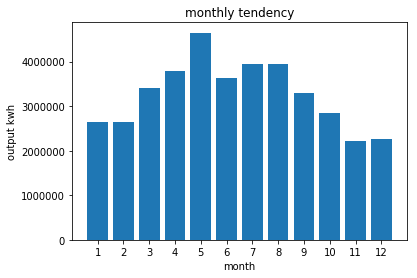

In [91]:
plt.bar(monthly_output['month'], monthly_output['SOLA01'], tick_label=np.arange(12)+1, width = 0.8)
plt.xlabel("month")
plt.ylabel("output kwh")
plt.title("monthly tendency")